In [1]:
import matplotlib.pyplot as plt
import legendstyles

In [2]:
plt.style.use(legendstyles.LEGEND)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import datetime
import pandas   as pd
import numpy    as np

import matplotlib.pyplot as plt
import matplotlib.dates  as mdates

from datetime   import datetime, timezone
from legendmeta import LegendMetadata

lmeta = LegendMetadata('/Users/romoluque_c/Repositories/legend-metadata-ref-v2.1.0/')

from h5glance import H5Glance
from lgdo     import LH5Store

#import lgdo.lh5_store as lh5
import lgdo.lh5 as lh5

In [5]:
colors        = plt.rcParams['axes.prop_cycle'].by_key()['color']
data_path     = '/Users/romoluque_c/LEGEND/Event_rate_analysis_after_TAUP/skm_data/ref-v2.1.0/'

In [6]:
legend_colors = {'legend_grey':   '#CCCCCC', 'legend_blue':      '#07A9FF', 'legend_darkblue': '#1A2A5B',
                 'legend_orange': '#FF9E21', 'legend_green':     '#53BF0F', 'legend_violet':   '#BB19BF',
                 'legend_gold':   '#806318', 'legend_darkgreen': '#1A4D20', 'legend_purple':   '#66283A',
                 'black':         '#000000', 'red':              '#B9123E', 'yellow':          '#ffc74e',
                 'green':         '#39a974', 'purple':           '#8A1859', 'silver':          '#BFC2C7',
                 'salmon':        '#FFB0A8', 'violet':           '#B580CA', 'darkblue':        '#203769',
                 'grey':          '#909090', 'gray':             '#909090', '1sigma_green':    '#83C369',
                 '2sigma_yellow': '#FDED95', 'mint':             '#85F7C2', 'forestgreen':     '#105D20',
                 'orange':        '#E77D4D', 'darkred':          '#9D0008', 'sand':            '#EDDAB7',
                 'lightgrey':     '#DCDCDC', 'lightgray':        '#DCDCDC', 'jet':             '#393939',
                 'teal':          '#149A9A'}

In [7]:
skm_files = [file for file in os.listdir(data_path) if file.endswith("skm.lh5")]

def sort_key(filename):
    parts  = filename.split('-')
    period = parts[1]  # Extract period (p03, p04, etc.)
    run    = parts[2]  # Extract run (r000, r001, etc.)
    return (period, run)

sorted_skm_files = sorted(skm_files, key=sort_key)

In [8]:
df_list = []
for file in sorted_skm_files:
    df_temp = lh5.read_as("/skm", data_path + file, "pd")
    period, run = sort_key(file)
    df_temp['period'] = int(period[1:])
    df_temp['run'   ] = int(run   [1:])
    df_list.append(df_temp)
df_skm = pd.concat(df_list, ignore_index=True)

df_skm['trigger_timestamp'] = pd.to_datetime(df_skm['trigger_timestamp'], unit='s') ## Required to compute the event rates!!

In [9]:
timestamp = "20230311T235840Z"
chmap     = lmeta.hardware.configuration.channelmaps.on(timestamp=timestamp)
diodes    = lmeta.hardware.detectors.germanium.diodes
geds      = chmap.map("system", unique=False)["geds"]
geds      = geds.map("daq.rawid")

ged_names     = {}
ged_types     = {}
ged_masses    = {}
ged_strings   = {}
ged_positions = {}

for rawid, val in geds.items():
    ged_names    [rawid] = val.name
    ged_types    [rawid] = diodes[val.name]['type']
    ged_masses   [rawid] = diodes[val.name]['production']['mass_in_g']
    ged_strings  [rawid] = chmap [val.name].location['string']#[]
    ged_positions[rawid] = chmap [val.name].location['position']#[]

df_skm['geds_name']     = df_skm['geds_rawid'].map(ged_names)
df_skm['geds_type']     = df_skm['geds_rawid'].map(ged_types)
df_skm['geds_mass']     = df_skm['geds_rawid'].map(ged_masses)
df_skm['geds_string']   = df_skm['geds_rawid'].map(ged_strings)
df_skm['geds_position'] = df_skm['geds_rawid'].map(ged_positions)

In [10]:
## Remove muon events and P00748A from p06 and p07 (ringing)

mask_muons   =  df_skm.coincident_muon==True
mask_ringing = (df_skm.geds_name=='P00748A') & (df_skm.period==6) & (df_skm.period==7)

df_skm = df_skm[~(mask_muons & mask_ringing)]

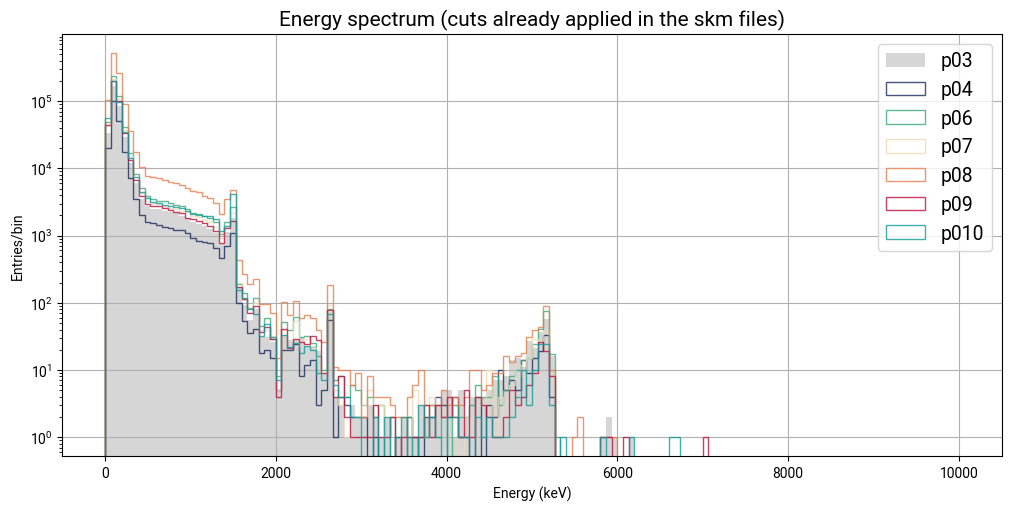

In [12]:
colors_per = ['legend_grey', 'legend_darkblue', 'green', 'sand', 'orange', 'red', 'teal']

fig, ax = plt.subplots(figsize=(10, 5))
for period, col in zip(df_skm.period.unique(), colors_per):
    df_skm_per = df_skm[df_skm.period==period]
    if period ==3:
        df_skm_per.geds_energy.hist(bins=150, range=(0, 10000), log=True, alpha=0.8, label=f'p0{period}', color=legend_colors[col])
    else:
        df_skm_per.geds_energy.hist(bins=150, range=(0, 10000), log=True, alpha=0.8, label=f'p0{period}', histtype='step', color=legend_colors[col])
plt.title('Energy spectrum (cuts already applied in the skm files)', fontsize=15)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bin')
plt.legend(loc=1, fontsize=14);

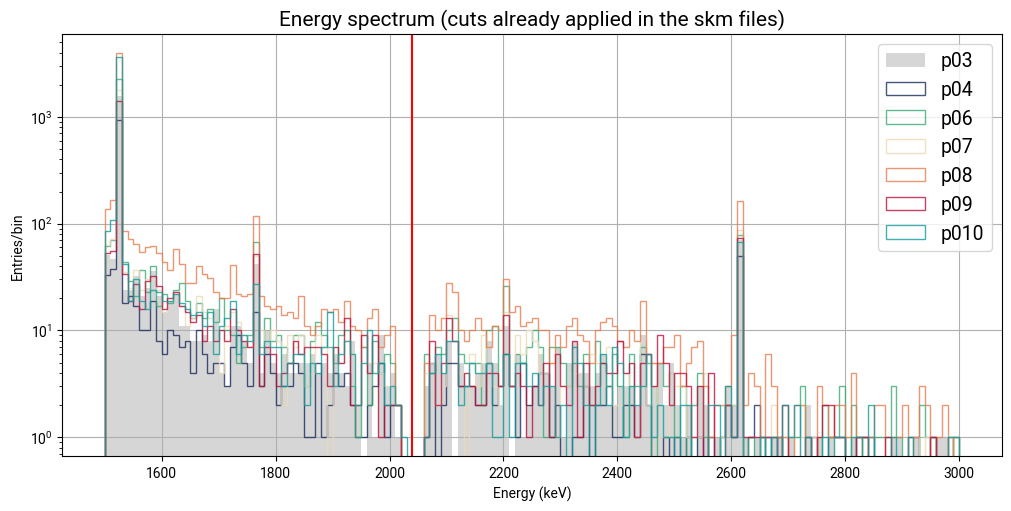

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
for period, col in zip(df_skm.period.unique(), colors_per):
    df_skm_per = df_skm[df_skm.period==period]
    if period ==3:
        df_skm_per.geds_energy.hist(bins=150, range=(1500, 3000), log=True, alpha=0.8, label=f'p0{period}', color=legend_colors[col])
    else:
        df_skm_per.geds_energy.hist(bins=150, range=(1500, 3000), log=True, alpha=0.8, label=f'p0{period}', histtype='step', color=legend_colors[col])
plt.axvline(x=2039, color='r')
plt.title('Energy spectrum (cuts already applied in the skm files)', fontsize=15)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bin')
plt.legend(loc=1, fontsize=14);

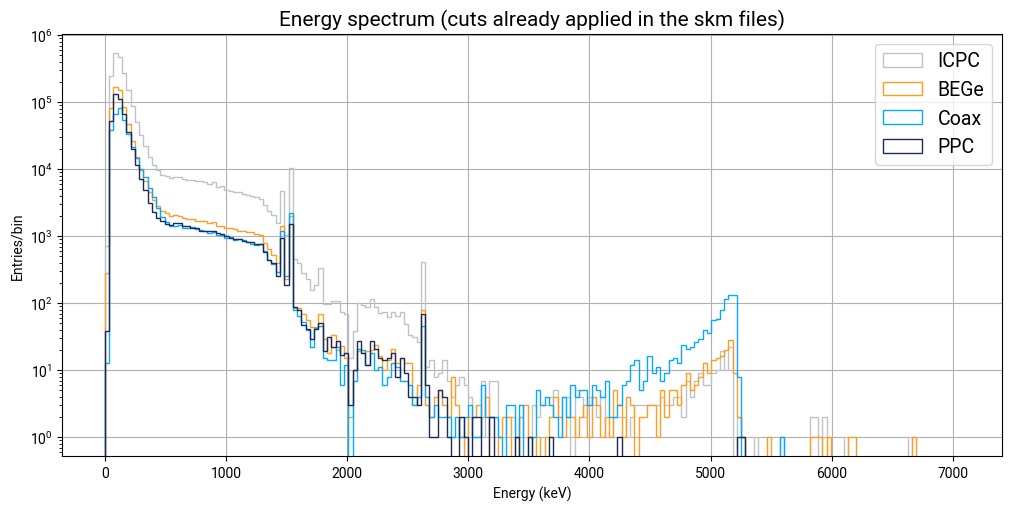

In [14]:
det_colors = ['#BFC2C7', '#FF9E21', '#07A9FF', '#1A2A5B']

fig, ax = plt.subplots(figsize=(10, 5))
for i, (det_type, det_type_nice) in enumerate(zip(['icpc', 'bege', 'coax', 'ppc'], ['ICPC', 'BEGe', 'Coax', 'PPC'])):    
    
    data_det   = df_skm[df_skm['geds_type']==det_type]
    data_det.geds_energy.hist(bins=200, range=(0, 7050), log=True, label=f'{det_type_nice}', color=det_colors[i], histtype='step')

plt.title('Energy spectrum (cuts already applied in the skm files)', fontsize=15)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bin')
plt.legend(loc=1, fontsize=14);

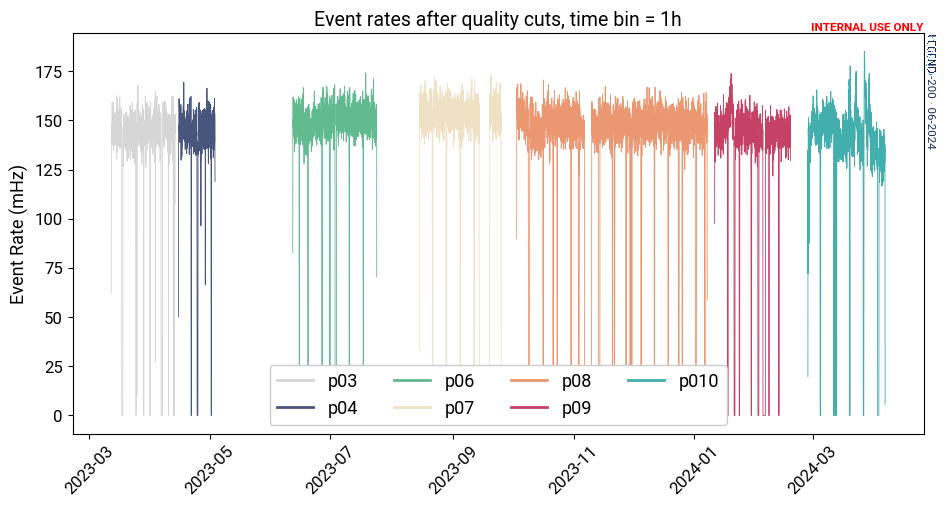

In [15]:
freq = '1H'

fig, ax = plt.subplots(figsize=(10, 5))
for period, col in zip(df_skm.period.unique(), colors_per):
    df_skm_per = df_skm[df_skm.period==period]
    g_data_p = df_skm_per.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
    plt.plot(g_data_p.index, g_data_p, label=f'p0{period}', color=legend_colors[col], lw=0.6, alpha=0.8)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)',              fontsize=13)
plt.title('Event rates after quality cuts, time bin = 1h', fontsize=14)
leg = plt.legend(fontsize=13, ncol=4, framealpha=1, loc='lower center')
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

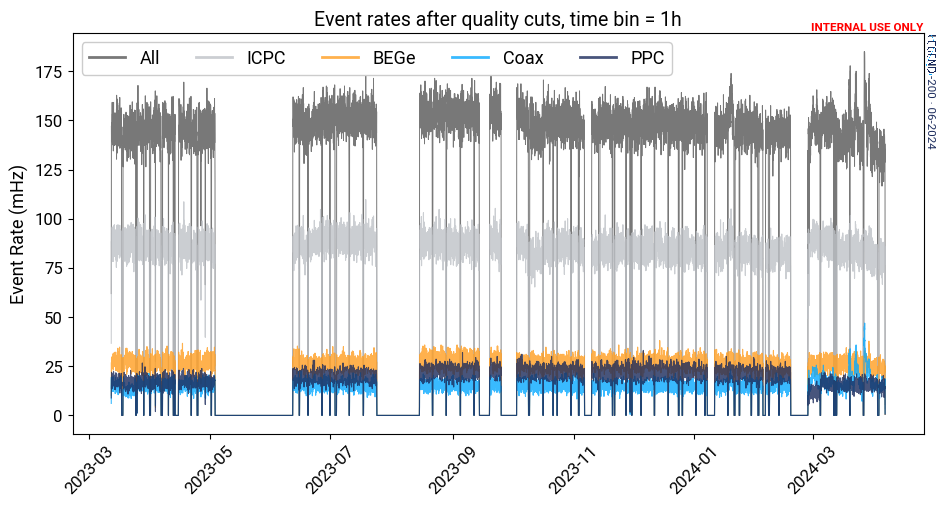

In [38]:
det_colors = ['#BFC2C7', '#FF9E21', '#07A9FF', '#1A2A5B']
freq    = '1H'
fig, ax = plt.subplots(figsize=(10, 5))
g_data  = df_skm.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
plt.plot(g_data.index, g_data, label='All',  alpha=0.9, color='dimgrey', linewidth=0.7)
for i, (det_type, det_type_nice) in enumerate(zip(['icpc', 'bege', 'coax', 'ppc'], ['ICPC', 'BEGe', 'Coax', 'PPC'])):    
    data_det   = df_skm[df_skm['geds_type']==det_type]
    g_data_det = data_det.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
    plt.plot(g_data_det.index, g_data_det, label=f'{det_type_nice}',  alpha=0.8, color=det_colors[i], linewidth=0.8)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)',              fontsize=13)
plt.title('Event rates after quality cuts, time bin = 1h', fontsize=14)
leg = plt.legend(fontsize=13, ncol=5, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

In [17]:
def resample_df_norm_mass(df, timestamp='H', time_column='trigger_timestamp'):
    """
    returns the event rates in mHz normalizing with the mass of each detector
    """
    df[time_column]      = pd.to_datetime(df[time_column], unit='s')  # Assuming the timestamp is in seconds
    df                   = df.set_index(time_column)
    event_rate_df        = df.resample(timestamp).size()
    event_rate_df_series = pd.Series(event_rate_df.values * (1000 / 3600), index=event_rate_df.index)
    summed_mass          = df.resample(timestamp).sum().geds_mass / 1000  # Transform to kg
    event_rate_norm      = event_rate_df_series / summed_mass
    return event_rate_norm.fillna(0)

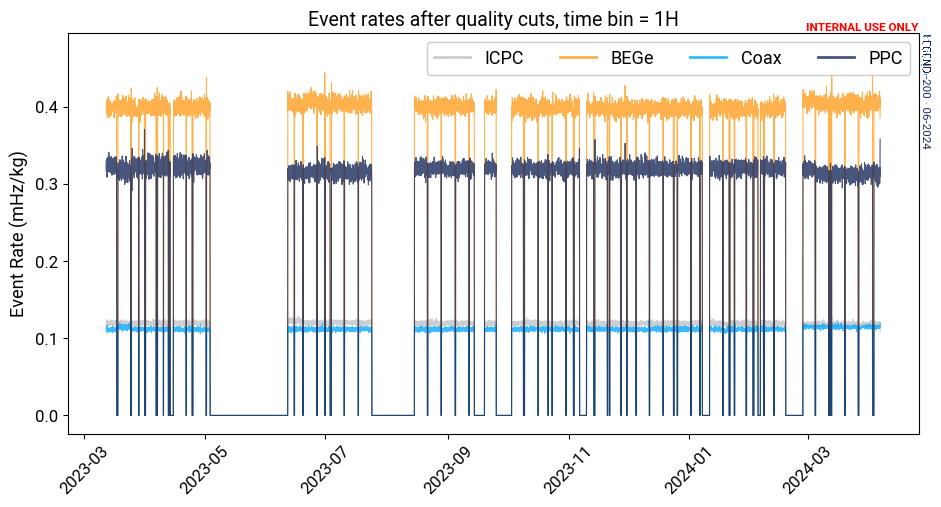

In [39]:
freq    = '1H'
fig, ax = plt.subplots(figsize=(10, 5))
for i, (det_type, det_type_nice) in enumerate(zip(['icpc', 'bege', 'coax', 'ppc'], ['ICPC', 'BEGe', 'Coax', 'PPC'])):    
    data_det   = df_skm[df_skm['geds_type']==det_type]
    data_filt_det_mass_series = resample_df_norm_mass(data_det)
    plt.plot(data_filt_det_mass_series.index, data_filt_det_mass_series, label=f'{det_type_nice}',  alpha=0.8, color=det_colors[i], linewidth=0.8)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz/kg)',              fontsize=13)
plt.title(f'Event rates after quality cuts, time bin = {freq}', fontsize=14)
leg = plt.legend(fontsize=13, ncol=5, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

## Energy ranges

In [19]:
energy_ranges = [(200,600), (900,1300), (1400,1600), (1900,2500), (2550,2700), (4500,5500)]
energy_colors = ['violet', 'red', 'legend_blue', 'teal', 'legend_darkblue', 'yellow']

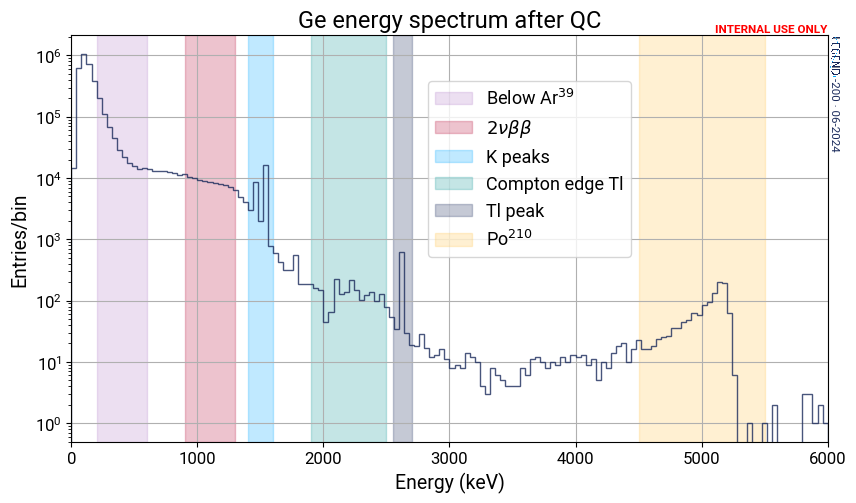

In [20]:
fig, ax = plt.subplots(figsize=(9, 5))
df_skm.geds_energy.hist(bins=150, range=(0, 6000), log=True, alpha=0.8, histtype='step', color=legend_colors['legend_darkblue'])
plt.axvspan(energy_ranges[0][0], energy_ranges[0][1], label=r'Below Ar$^{39}$',  color=legend_colors[energy_colors[0]], alpha=0.25)
plt.axvspan(energy_ranges[1][0], energy_ranges[1][1], label=r'$2\nu\beta\beta$', color=legend_colors[energy_colors[1]], alpha=0.25)
plt.axvspan(energy_ranges[2][0], energy_ranges[2][1], label='K peaks'          , color=legend_colors[energy_colors[2]], alpha=0.25)
plt.axvspan(energy_ranges[3][0], energy_ranges[3][1], label='Compton edge Tl'  , color=legend_colors[energy_colors[3]], alpha=0.25)
plt.axvspan(energy_ranges[4][0], energy_ranges[4][1], label='Tl peak'          , color=legend_colors[energy_colors[4]], alpha=0.25)
plt.axvspan(energy_ranges[5][0], energy_ranges[5][1], label=r'Po$^{210}$'      , color=legend_colors[energy_colors[5]], alpha=0.25)
plt.title('Ge energy spectrum after QC', fontsize=17)
plt.xlabel('Energy (keV)', fontsize=14)
plt.ylabel('Entries/bin' , fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(0.46, 0.91), fontsize=13)
plt.xlim(0, 6000)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

In [21]:
def resample_df(df, timestamp='H', time_column='trigger_timestamp'): ## returns the event rates in mHz (evt rate per hour /3600 sec *1000 mHz)
    df[time_column]      = pd.to_datetime(df[time_column], unit='s')  # Assuming the timestamp is in seconds
    df                   = df.set_index(time_column)
    event_rate_df        = df.resample(timestamp).size()
    event_rate_df_series = pd.Series(event_rate_df.values*(1000/3600), index=event_rate_df.index)
    return event_rate_df_series

def evt_arte_energy_cuts(df, e1, e2, timest='1H'):
    df_e = df[(df.geds_energy>e1)&(df.geds_energy<=e2)]
    df_e_series = resample_df(df_e, timest)
    return df_e_series

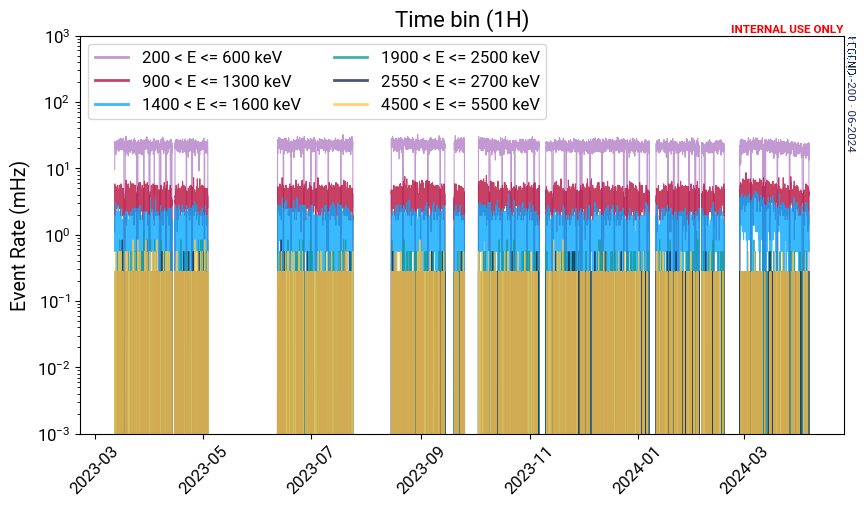

In [22]:
timestamp = '1H'

fig, ax = plt.subplots(figsize=(9, 5))
for (e1, e2), col in zip(energy_ranges, energy_colors):
    data_e_sr = evt_arte_energy_cuts(df_skm, e1, e2, timest=timestamp)
    plt.plot(data_e_sr.index, data_e_sr, lw=0.8, color=legend_colors[col], alpha=0.8, label=f'{e1} < E <= {e2} keV')
plt.title(f'Time bin ({timestamp})', fontsize=16)
plt.ylabel('Event Rate (mHz)', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylim(10**(-3), 10**3)
plt.yscale('log')

leg = ax.legend(ncol=2, fontsize=12, loc='upper left')
for line in leg.get_lines():
    line.set_linewidth(2)

legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

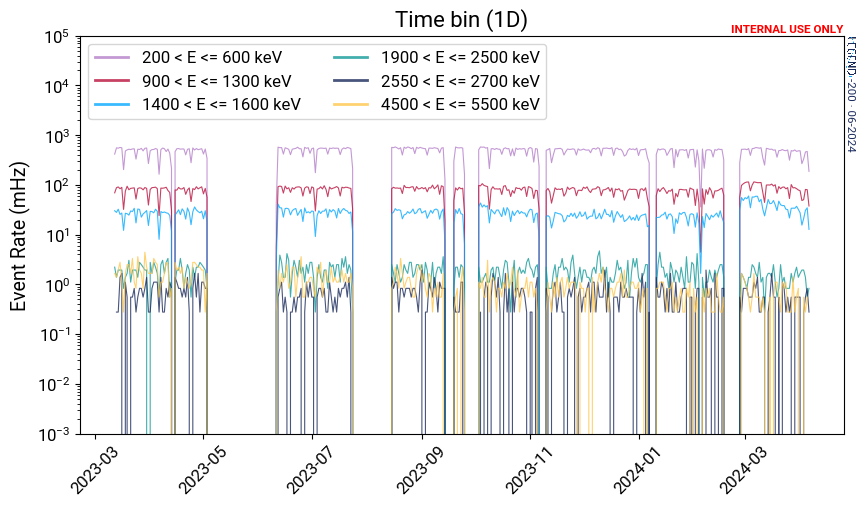

In [23]:
timestamp = '1D'

fig, ax = plt.subplots(figsize=(9, 5))
for (e1, e2), col in zip(energy_ranges, energy_colors):
    data_e_sr = evt_arte_energy_cuts(df_skm, e1, e2, timest=timestamp)
    plt.plot(data_e_sr.index, data_e_sr, lw=0.8, color=legend_colors[col], alpha=0.8, label=f'{e1} < E <= {e2} keV')
plt.title(f'Time bin ({timestamp})', fontsize=16)
plt.ylabel('Event Rate (mHz)', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylim(10**(-3), 10**5)
plt.yscale('log')

leg = ax.legend(ncol=2, fontsize=12, loc='upper left')
for line in leg.get_lines():
    line.set_linewidth(2)

legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

### Splitting each period:

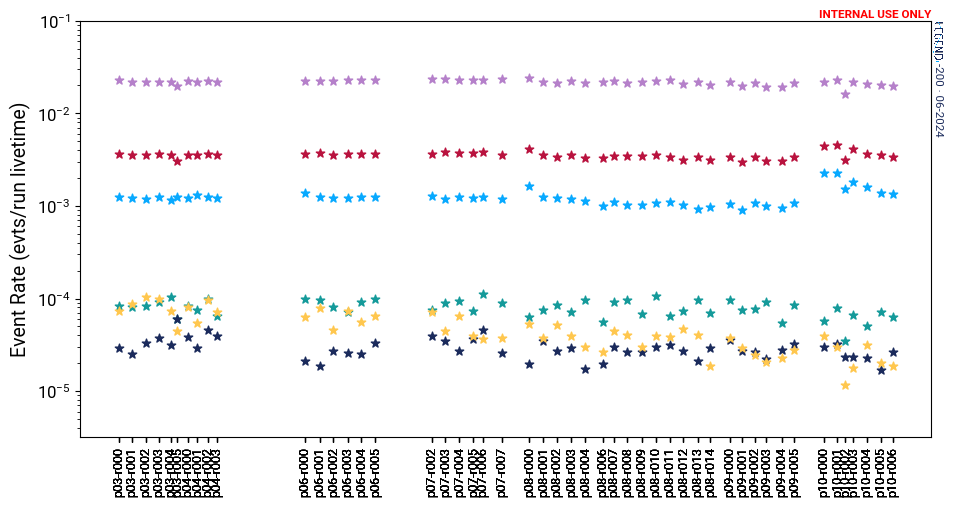

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
midpoints       = []
midpoint_labels = []
for (e1, e2), col in zip(energy_ranges, energy_colors):
    gold_evts_per_run = []
    for period in df_skm.period.sort_values().unique():
        for run in df_skm[df_skm.period==period].run.sort_values().unique():
            df_period_run   = df_skm[(df_skm.period==period)&(df_skm.run==run)]
            livetime        = df_period_run.trigger_timestamp.max() - df_period_run.trigger_timestamp.min()
            livetime_s      = livetime.total_seconds()
            midpoint        = df_period_run.trigger_timestamp.mean()
            df_period_run_e = df_period_run[(df_period_run.geds_energy>e1)&(df_period_run.geds_energy<=e2)]
            ax.scatter(midpoint, len(df_period_run_e)/livetime_s, marker='*', s=40, color=legend_colors[col], label=f'{e1} < E <= {e2} keV')
            
            midpoints      .append(midpoint)
            midpoint_labels.append(f'p{period:02d}-r{run:03d}')

plt.title(f'', fontsize=15)
plt.ylabel('Event Rate (evts/run livetime)', fontsize=14)
ax.set_xticks(midpoints)
ax.set_xticklabels(midpoint_labels, rotation=90, fontsize=9)  # Use numeric labels
plt.ylim(10**(-5.5), 10**(-1))
plt.yticks(fontsize=12)
plt.yscale('log')
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

## Golden dataset:

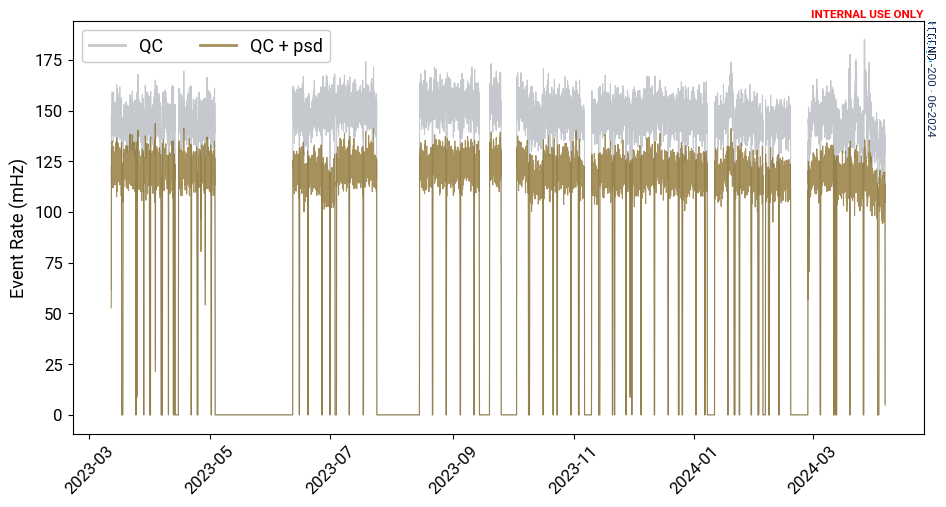

In [40]:
freq    = '1H'

fig, ax     = plt.subplots(figsize=(10, 5))
g_data      = df_skm.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
data_golden = df_skm[df_skm.geds_psd_is_good==True]
g_data_det  = data_golden.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)

plt.plot(g_data.index,     g_data,     label='QC', alpha=0.9, color=legend_colors['silver'],      lw=0.8)
plt.plot(g_data_det.index, g_data_det, label='QC + psd', alpha=0.7, color=legend_colors['legend_gold'], lw=0.8)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)',              fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

In [ ]:
colors_per = ['legend_grey', 'legend_darkblue', 'green', 'sand', 'orange', 'red', 'teal']


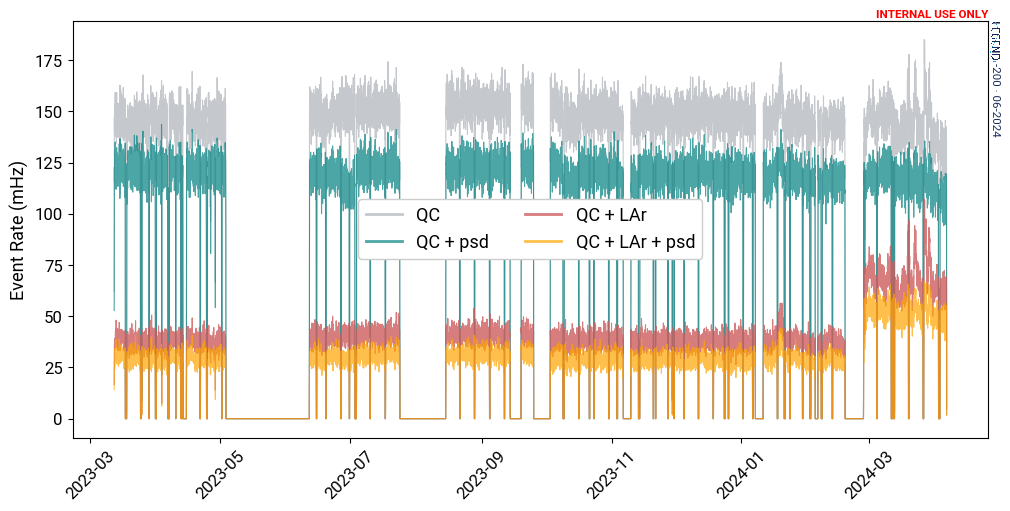

In [167]:
freq    = '1H'

fig, ax     = plt.subplots(figsize=(10, 5))
g_data      = df_skm.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
data_golden = df_skm[df_skm.geds_psd_is_good==True]
g_data_det  = data_golden.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
data_LAr    = df_skm[df_skm.coincident_spms==False]
data_LAr_s  = data_LAr.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
data_LAr_g    = data_golden[data_golden.coincident_spms==False]
data_LAr_g_s  = data_LAr_g.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)

plt.plot(g_data      .index, g_data,       label='QC',             alpha=0.9, color=legend_colors['silver'],       lw=0.8)
plt.plot(g_data_det  .index, g_data_det,   label='QC + psd',       alpha=0.7, color='teal',  lw=0.8)
plt.plot(data_LAr_s  .index, data_LAr_s,   label='QC + LAr',       alpha=0.8, color='indianred',  lw=0.8)
plt.plot(data_LAr_g_s.index, data_LAr_g_s, label='QC + LAr + psd', alpha=0.7, color='orange', lw=0.8)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)',              fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
#plt.savefig('/Users/romoluque_c/LEGEND/Event_rate_analysis_after_TAUP/event_rates_ref-v2.1.0_all_QC.pdf', bbox_inches='tight')
plt.show()

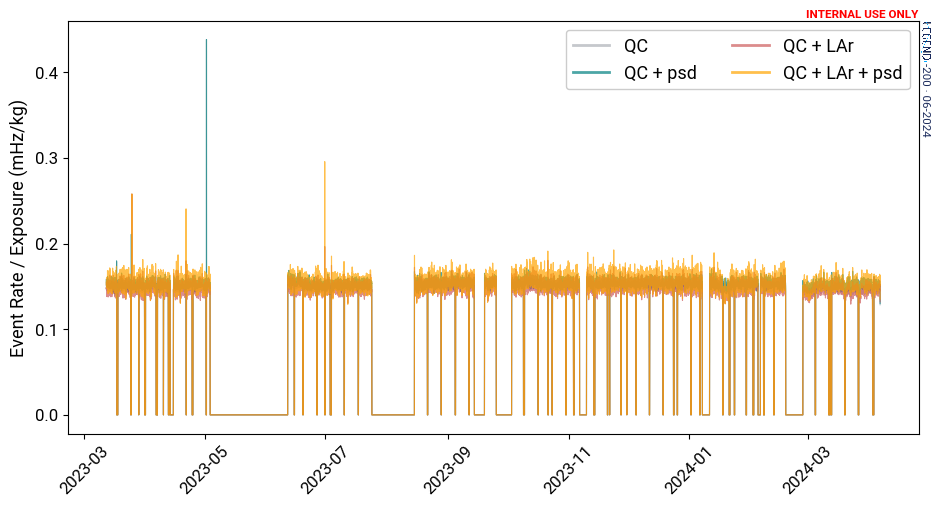

In [168]:
freq    = '1H'

fig, ax     = plt.subplots(figsize=(10, 5))
g_data_m      = resample_df_norm_mass(df_skm)
data_golden_m = resample_df_norm_mass(df_skm[df_skm.geds_psd_is_good==True])
data_LAr_m    = resample_df_norm_mass(df_skm[df_skm.coincident_spms==False])
data_LAr_g_m  = resample_df_norm_mass(data_golden[data_golden.coincident_spms==False])

plt.plot(g_data_m     .index, g_data_m,      label='QC',             alpha=0.9, color=legend_colors['silver'],      lw=0.8)
plt.plot(data_golden_m.index, data_golden_m, label='QC + psd',       alpha=0.7, color='teal', lw=0.8)
plt.plot(data_LAr_m   .index, data_LAr_m,    label='QC + LAr',       alpha=0.7, color='indianred', lw=0.8)
plt.plot(data_LAr_g_m .index, data_LAr_g_m,  label='QC + LAr + psd', alpha=0.7, color='orange', lw=0.8)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate / Exposure (mHz/kg)',              fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

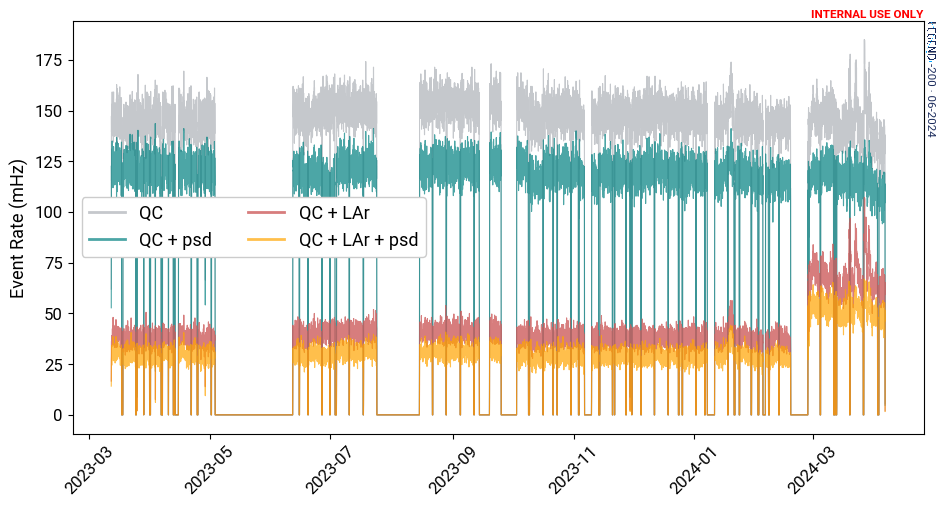

In [172]:
freq    = '1H'

fig, ax     = plt.subplots(figsize=(10, 5))
g_data      = df_skm.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
data_golden = df_skm[df_skm.geds_psd_is_good==True]
g_data_det  = data_golden.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
data_LAr    = df_skm[df_skm.coincident_spms==False]
data_LAr_s  = data_LAr.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
data_LAr_g    = data_golden[data_golden.coincident_spms==False]
data_LAr_g_s  = data_LAr_g.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)

plt.plot(g_data      .index, g_data,       label='QC',             alpha=0.9, color=legend_colors['silver'],       lw=0.8)
plt.plot(g_data_det  .index, g_data_det,   label='QC + psd',       alpha=0.7, color='teal',  lw=0.8)
plt.plot(data_LAr_s  .index, data_LAr_s,   label='QC + LAr',       alpha=0.8, color='indianred',  lw=0.8)
plt.plot(data_LAr_g_s.index, data_LAr_g_s, label='QC + LAr + psd', alpha=0.7, color='orange', lw=0.8)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)',              fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
#plt.savefig('/Users/romoluque_c/LEGEND/Event_rate_analysis_after_TAUP/event_rates_ref-v2.1.0_all_QC.pdf', bbox_inches='tight')
plt.show()

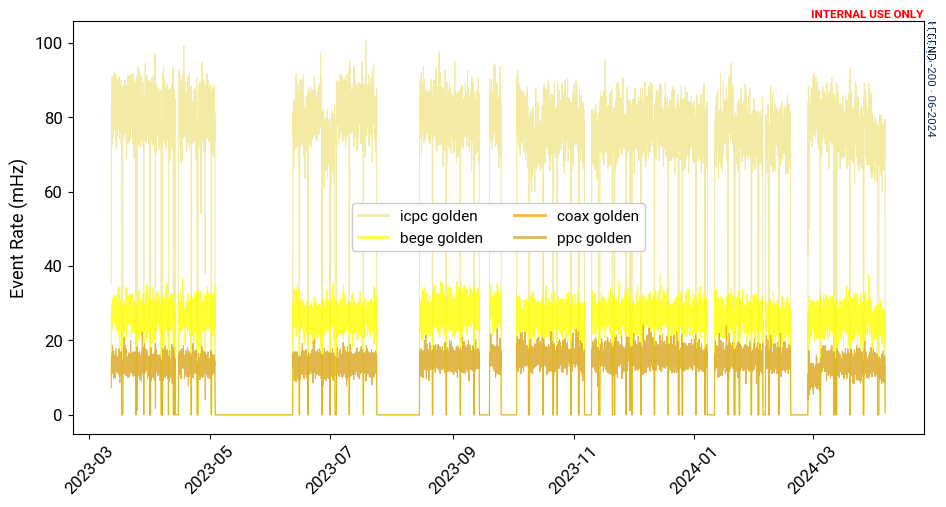

In [26]:
timestamp = '1H'
fig, ax     = plt.subplots(figsize=(10, 5))
for d_type, col1, col2 in zip(['icpc', 'bege', 'coax', 'ppc'], ['khaki', 'yellow', 'orange', 'goldenrod'], ['silver', 'k', 'darkblue', 'darkgrey']):
    data_silver = df_skm[df_skm.geds_type==d_type]
    
    data_golden   = data_silver[data_silver.geds_psd_is_good == True]
    data_golden_s = resample_df(data_golden, timestamp=timestamp)
    data_silver_s = resample_df(data_silver, timestamp=timestamp)
    #ax.plot(data_silver_s.index, data_silver_s, lw=0.8, color=col2, alpha=0.8, label=f'{d_type} silver', zorder=1)
    ax.plot(data_golden_s.index, data_golden_s, lw=0.8, color=col1, alpha=0.8, label=f'{d_type} golden', zorder=1)

plt.ylabel('Event Rate (mHz)')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)', fontsize=13)
leg = plt.legend(fontsize=11, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

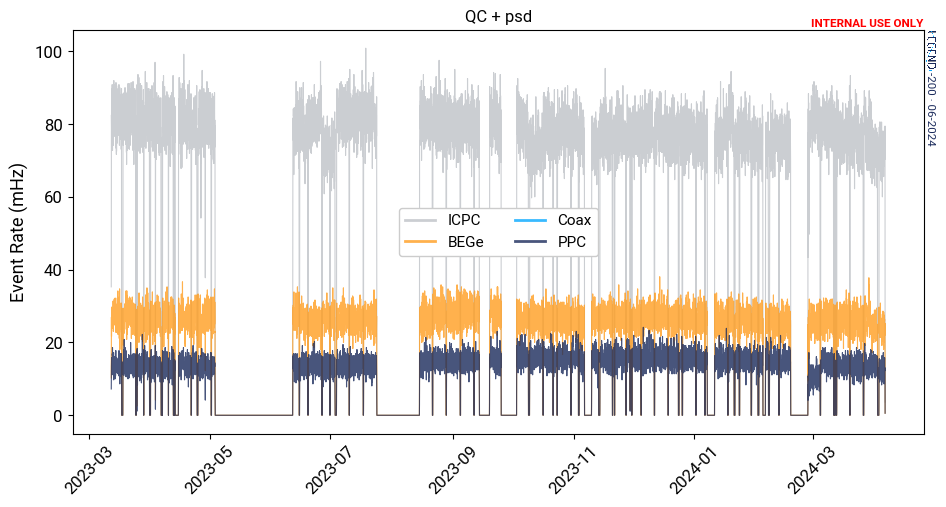

In [43]:
timestamp = '1H'
fig, ax     = plt.subplots(figsize=(10, 5))
for d_type, dtype_nice, col in zip(['icpc', 'bege', 'coax', 'ppc'], ['ICPC', 'BEGe', 'Coax', 'PPC'], det_colors):
    data_silver = df_skm[df_skm.geds_type==d_type]
    
    data_golden   = data_silver[data_silver.geds_psd_is_good == True]
    data_golden_s = resample_df(data_golden, timestamp=timestamp)
    data_silver_s = resample_df(data_silver, timestamp=timestamp)
    ax.plot(data_golden_s.index, data_golden_s, lw=0.8, color=col, alpha=0.8, label=f'{dtype_nice}', zorder=1)

plt.title('QC + psd')
plt.ylabel('Event Rate (mHz)')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)', fontsize=13)
leg = plt.legend(fontsize=11, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

## LAr rejection

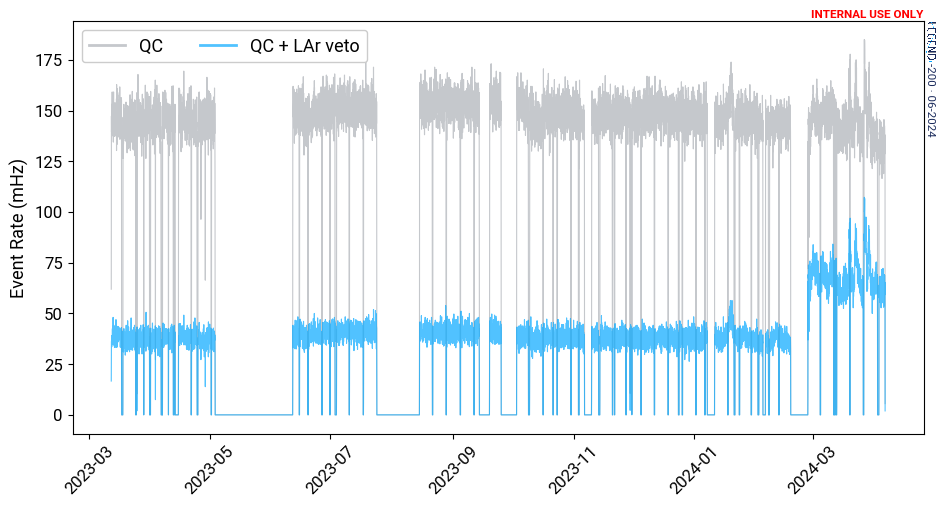

In [45]:
freq = '1H'

fig, ax     = plt.subplots(figsize=(10, 5))
g_data      = df_skm.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
data_LAr    = df_skm[df_skm.coincident_spms==False]
g_data_LAr  = data_LAr.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)

plt.plot(g_data.index,     g_data,     label='QC',             alpha=0.9, color=legend_colors['silver'],      lw=0.8)
plt.plot(g_data_LAr.index, g_data_LAr, label=f'QC + LAr veto', alpha=0.7, color=legend_colors['legend_blue'], lw=0.8)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)',              fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

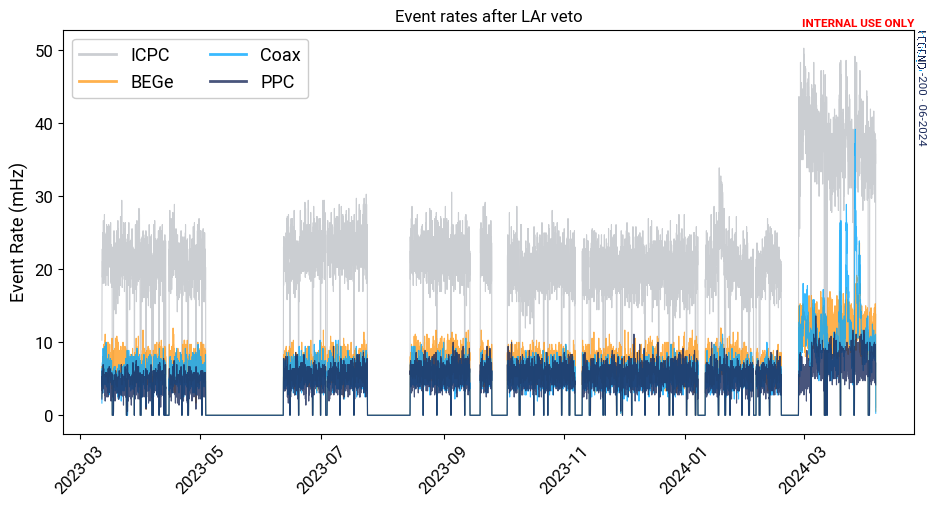

In [153]:
freq = '1H'

fig, ax    = plt.subplots(figsize=(10, 5))
#g_data     = df_skm.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
data_LAr   = df_skm[df_skm.coincident_spms==False]
g_data_LAr = data_LAr.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
#plt.plot(g_data.index,     g_data,     label='QC',             alpha=0.9, color=legend_colors['silver'],      lw=0.8)
#plt.plot(g_data_LAr.index, g_data_LAr, label=f'LAr reject all detectors', alpha=0.7, color=legend_colors['grey'], lw=0.8)

for d_type, dtype_nice, col in zip(['icpc', 'bege', 'coax', 'ppc'], ['ICPC', 'BEGe', 'Coax', 'PPC'], det_colors):
    g_data_LAr_det = data_LAr[data_LAr.geds_type==d_type]
    
    g_data_LAr_det_s = resample_df(g_data_LAr_det, timestamp=timestamp)
    ax.plot(g_data_LAr_det_s.index, g_data_LAr_det_s, lw=0.8, color=col, alpha=0.8, label=f'{dtype_nice}', zorder=1)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title('Event rates after LAr veto')
plt.ylabel('Event Rate (mHz)', fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

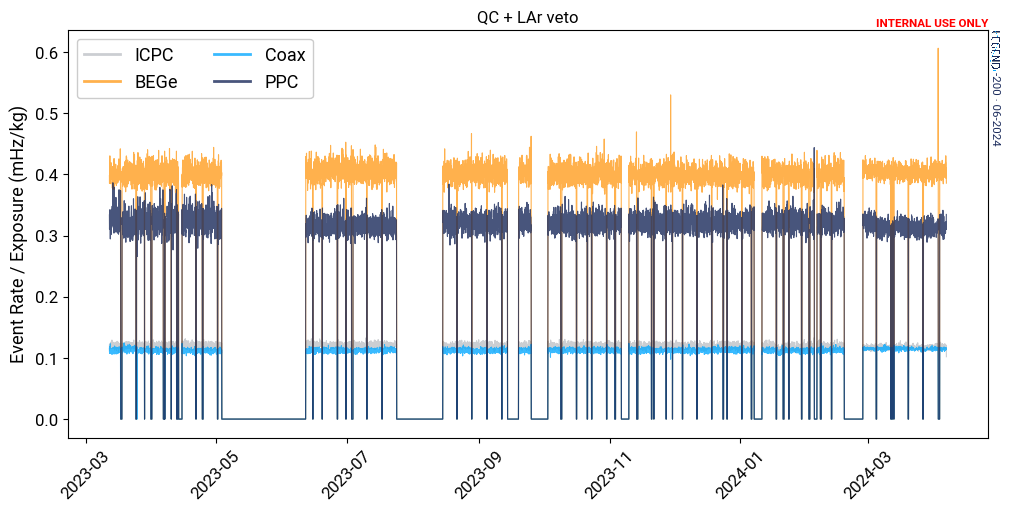

In [157]:
freq = '1H'

fig, ax    = plt.subplots(figsize=(10, 5))
data_LAr   = df_skm[df_skm.coincident_spms==False]
g_data_LAr = data_LAr.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)

for d_type, dtype_nice, col in zip(['icpc', 'bege', 'coax', 'ppc'], ['ICPC', 'BEGe', 'Coax', 'PPC'], det_colors):
    g_data_LAr_det   = data_LAr[data_LAr.geds_type==d_type]
    g_data_LAr_det_s = df_each_coax_mass = resample_df_norm_mass(g_data_LAr_det, timestamp=freq)
    ax.plot(g_data_LAr_det_s.index, g_data_LAr_det_s, lw=0.8, color=col, alpha=0.8, label=f'{dtype_nice}', zorder=1)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title('QC + LAr veto')
plt.ylabel('Event Rate / Exposure (mHz/kg)', fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
#plt.savefig('event_rates_ref-v2.1.0_qc_LAr_det_normalized.pdf', bbox_inches='tight')
plt.show()

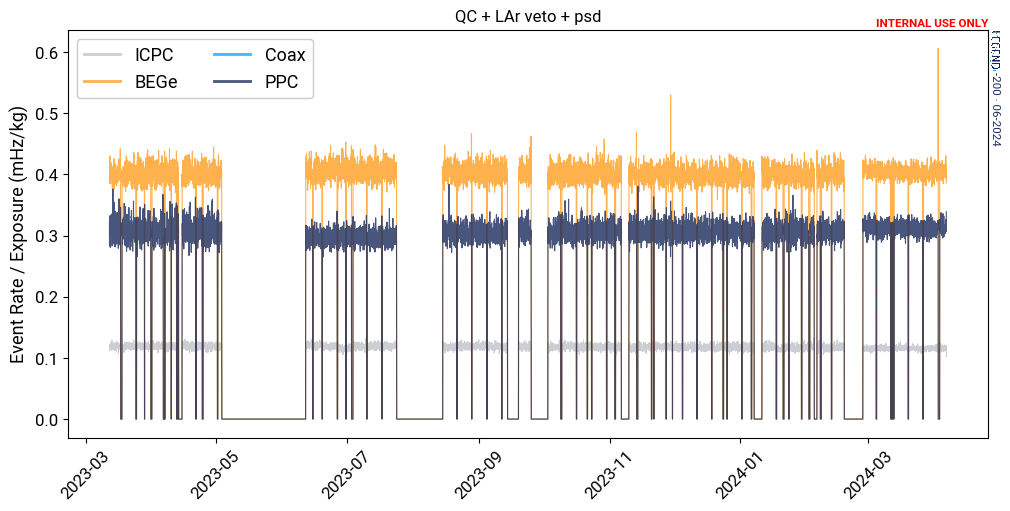

In [173]:
freq = '1H'

fig, ax    = plt.subplots(figsize=(10, 5))
data_LAr_psd   = df_skm[(df_skm.coincident_spms==False)&(df_skm.geds_psd_is_good==True)]

for d_type, dtype_nice, col in zip(['icpc', 'bege', 'coax', 'ppc'], ['ICPC', 'BEGe', 'Coax', 'PPC'], det_colors):
    data_LAr_psd_det   = data_LAr_psd[data_LAr_psd.geds_type==d_type]
    data_LAr_psd_det_s = resample_df_norm_mass(data_LAr_psd_det, timestamp=freq)
    ax.plot(data_LAr_psd_det_s.index, data_LAr_psd_det_s, lw=0.8, color=col, alpha=0.8, label=f'{dtype_nice}', zorder=1)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title('QC + LAr veto + psd')
plt.ylabel('Event Rate / Exposure (mHz/kg)', fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.savefig('/Users/romoluque_c/LEGEND/Event_rate_analysis_after_TAUP/event_rates_ref-v2.1.0_all_QC_det_norm.pdf', bbox_inches='tight')
plt.show()

In [29]:
legend_colors;

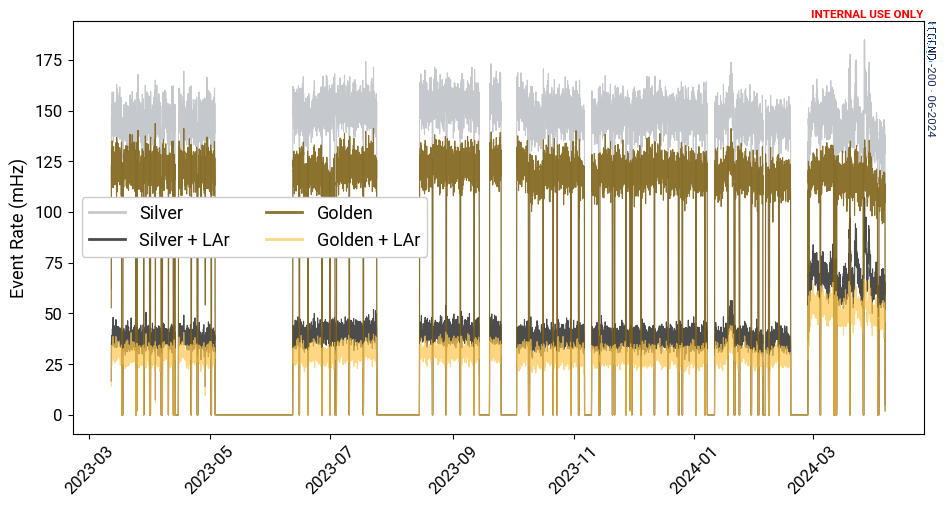

In [37]:
freq    = '1H'
fig, ax = plt.subplots(figsize=(10, 5))

for data_df, data_type, c1, c2 in zip([df_skm, df_skm[df_skm.geds_psd_is_good==True]], ['Silver', 'Golden'], ['silver', 'legend_gold'], ['black', 'yellow']):
    data_s     = data_df                                .groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
    data_s_LAr = data_df[data_df.coincident_spms==False].groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)

    plt.plot(data_s    .index, data_s,     label=data_type,          alpha=0.9, color=legend_colors[c1], lw=0.8)
    plt.plot(data_s_LAr.index, data_s_LAr, label=data_type+' + LAr', alpha=0.7, color=legend_colors[c2], lw=0.8)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)',              fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1, loc='center left')
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

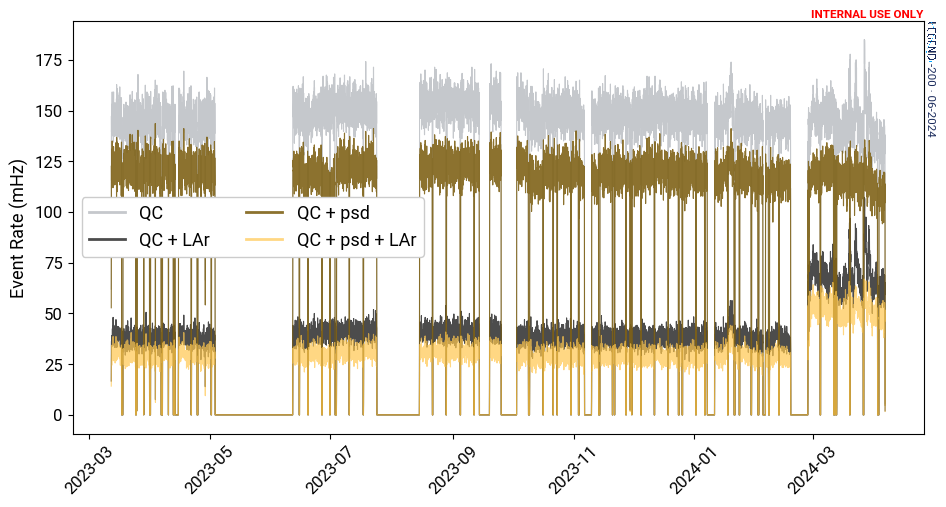

In [47]:
freq    = '1H'
fig, ax = plt.subplots(figsize=(10, 5))

for data_df, data_type, c1, c2 in zip([df_skm, df_skm[df_skm.geds_psd_is_good==True]], ['QC', 'QC + psd'], ['silver', 'legend_gold'], ['black', 'yellow']):
    data_s     = data_df                                .groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
    data_s_LAr = data_df[data_df.coincident_spms==False].groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)

    plt.plot(data_s    .index, data_s,     label=data_type,          alpha=0.9, color=legend_colors[c1], lw=0.8)
    plt.plot(data_s_LAr.index, data_s_LAr, label=data_type+' + LAr', alpha=0.7, color=legend_colors[c2], lw=0.8)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)',              fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1, loc='center left')
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

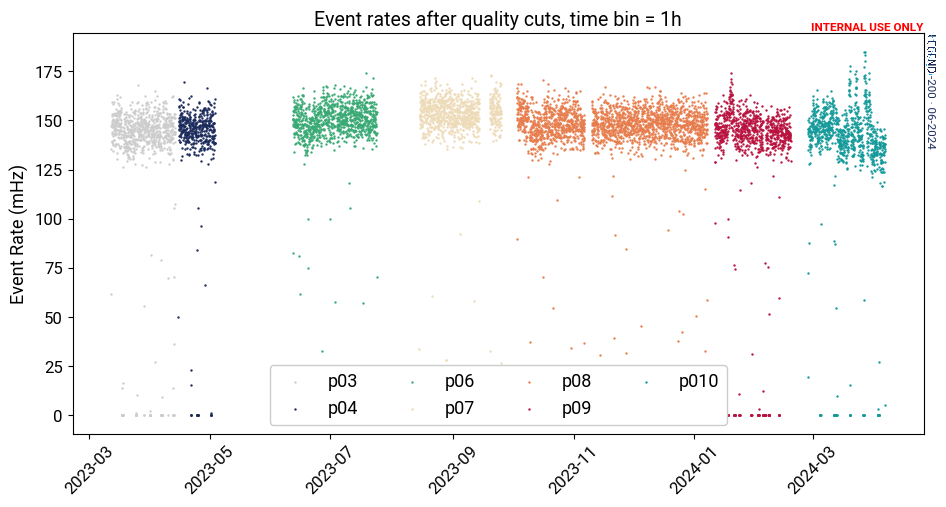

In [33]:
freq = '1H'

fig, ax = plt.subplots(figsize=(10, 5))
for period, col in zip(df_skm.period.unique(), colors_per):
    df_skm_per = df_skm[df_skm.period==period]
    g_data_p = df_skm_per.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
    plt.scatter(g_data_p.index, g_data_p, label=f'p0{period}', color=legend_colors[col], marker='.', s=2)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)',              fontsize=13)
plt.title('Event rates after quality cuts, time bin = 1h', fontsize=14)
leg = plt.legend(fontsize=13, ncol=4, framealpha=1, loc='lower center')
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

## Look at the coaxials

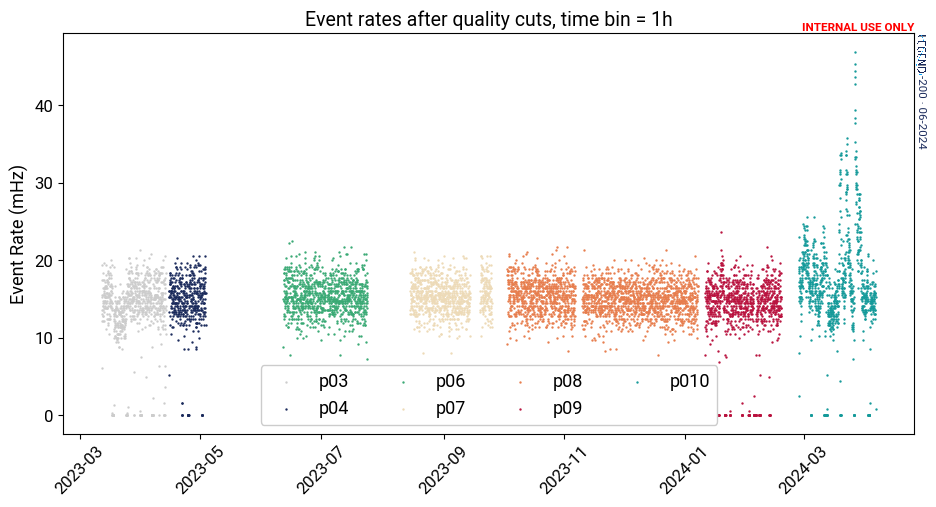

In [48]:
freq = '1H'

fig, ax = plt.subplots(figsize=(10, 5))
for period, col in zip(df_skm.period.unique(), colors_per):
    df_skm_per = df_skm[(df_skm.period==period)&(df_skm.geds_type=='coax')]
    g_data_p = df_skm_per.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
    plt.scatter(g_data_p.index, g_data_p, label=f'p0{period}', color=legend_colors[col], marker='.', s=2)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Event Rate (mHz)',              fontsize=13)
plt.title('Event rates after quality cuts, time bin = 1h', fontsize=14)
leg = plt.legend(fontsize=13, ncol=4, framealpha=1, loc='lower center')
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

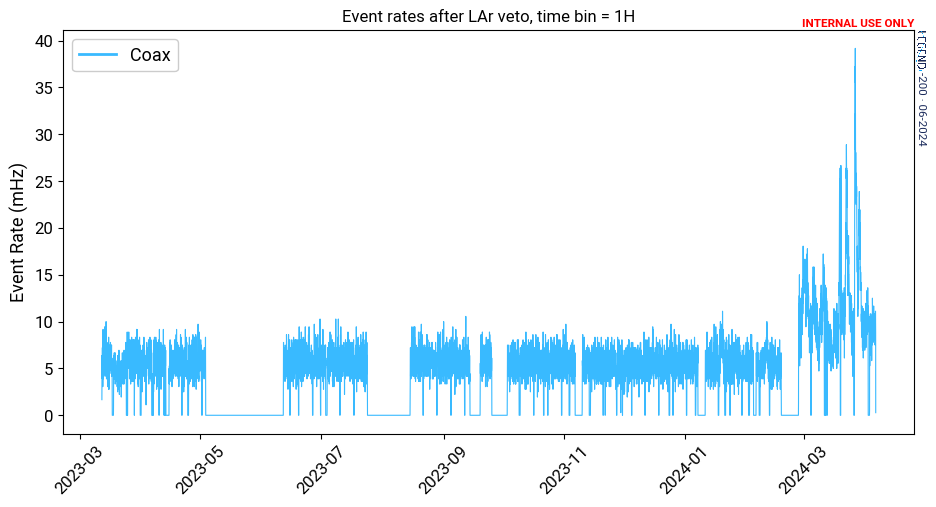

In [57]:
freq = '1H'

fig, ax         = plt.subplots(figsize=(10, 5))
data_LAr_coax   = df_skm[(df_skm.coincident_spms==False)&(df_skm.geds_type=='coax')]
g_data_LAr_coax = data_LAr_coax.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
ax.plot(g_data_LAr_coax.index, g_data_LAr_coax, lw=0.8, color=det_colors[2], alpha=0.8, label=f'Coax', zorder=1)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title(f'Event rates after LAr veto, time bin = {freq}')
plt.ylabel('Event Rate (mHz)', fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
plt.show()

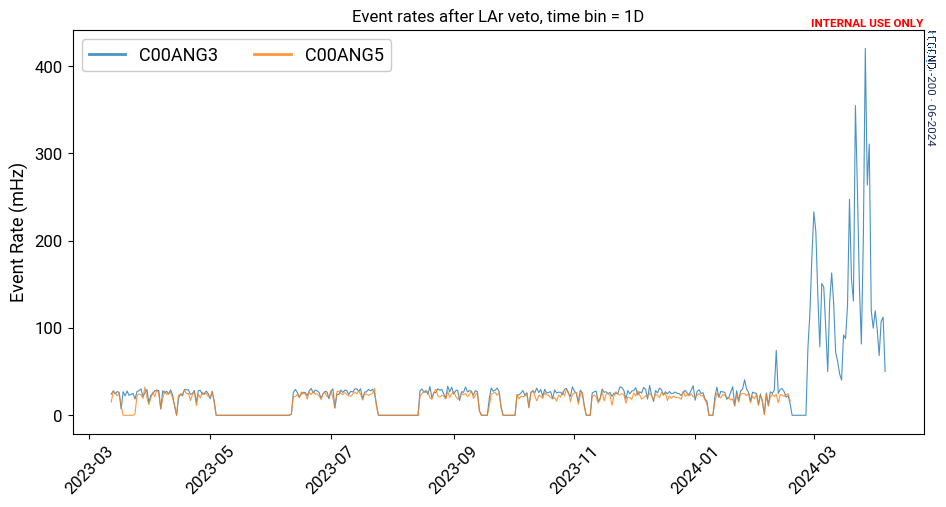

In [91]:
freq = '1D'

fig, ax         = plt.subplots(figsize=(10, 5))
data_LAr_coax   = df_skm[(df_skm.coincident_spms==False)&(df_skm.geds_type=='coax')]
g_data_LAr_coax = data_LAr_coax.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
#ax.plot(g_data_LAr_coax.index, g_data_LAr_coax, lw=0.8, color=det_colors[2], alpha=0.8, label=f'Coax', zorder=1)

for coax in data_LAr_coax.geds_name.unique():
    if coax=='C00ANG5' or coax=='C00ANG3':
        df_each_coax = data_LAr_coax[data_LAr_coax.geds_name==coax]
        g_data_det   = df_each_coax.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
        ax.plot(g_data_det.index, g_data_det, lw=0.8, alpha=0.8, label=coax, zorder=1)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title(f'Event rates after LAr veto, time bin = {freq}')
plt.ylabel('Event Rate (mHz)', fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
#plt.yscale('log')
plt.show()

In [83]:
data_LAr_coax   = df_skm[(df_skm.coincident_spms==False)&(df_skm.geds_type=='coax')&(df_skm.period==10)]
for coax in data_LAr_coax.geds_name.unique():
    print(coax, data_LAr_coax[data_LAr_coax.geds_name==coax].geds_mass.sum()/1000, 'kg')


C00ANG3 49947.18 kg
C000RG2 6393.432 kg
C00ANG2 15972.264 kg
C00ANG4 11585.25 kg
C000RG1 5827.654 kg


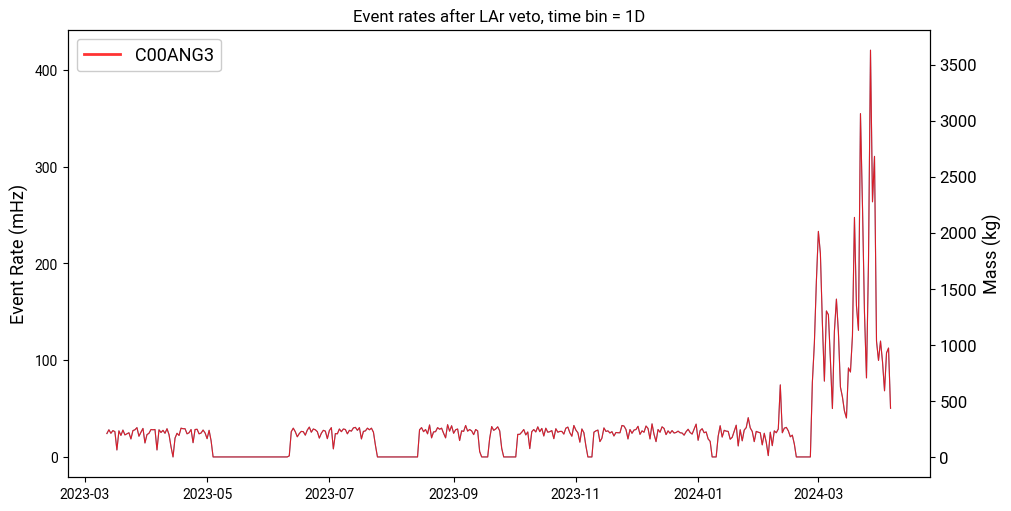

In [111]:
freq = '1D'

fig, ax         = plt.subplots(figsize=(10, 5))
data_LAr_coax   = df_skm[(df_skm.coincident_spms==False)&(df_skm.geds_type=='coax')]
g_data_LAr_coax = data_LAr_coax.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
#ax.plot(g_data_LAr_coax.index, g_data_LAr_coax, lw=0.8, color=det_colors[2], alpha=0.8, label=f'Coax', zorder=1)

for coax in data_LAr_coax.geds_name.unique():
    if coax=='C00ANG3':
        df_each_coax = data_LAr_coax[data_LAr_coax.geds_name==coax]
        g_data_det   = df_each_coax.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
        ax.plot(g_data_det.index, g_data_det, lw=0.8, alpha=0.8, label=coax, zorder=1)
        
        df_each_coax = df_each_coax.set_index('trigger_timestamp')
        summed_mass  = df_each_coax.resample(freq).geds_mass.sum() / 1000  # Transform to kg
        
        ax2 = ax.twinx()
        ax2.plot(summed_mass.index, summed_mass, lw=0.8, alpha=0.8, label=coax, zorder=1, color='r')
        ax2.set_ylabel('Mass (kg)', fontsize=13)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title(f'Event rates after LAr veto, time bin = {freq}')
ax.set_ylabel('Event Rate (mHz)', fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
#legendstyles.legend_watermark(ax, logo_suffix="-200")
#plt.yscale('log')
plt.show()

##
##def resample_df_norm_mass(df, timestamp='H', time_column='trigger_timestamp'):
##    """
##    returns the event rates in mHz normalizing with the mass of each detector
##    """
##    df[time_column]      = pd.to_datetime(df[time_column], unit='s')  # Assuming the timestamp is in seconds
##    df                   = df.set_index(time_column)
##    event_rate_df        = df.resample(timestamp).size()
##    event_rate_df_series = pd.Series(event_rate_df.values * (1000 / 3600), index=event_rate_df.index)
##    summed_mass          = df.resample(timestamp).sum().geds_mass / 1000  # Transform to kg
##    event_rate_norm      = event_rate_df_series / summed_mass
##    return event_rate_norm.fillna(0)

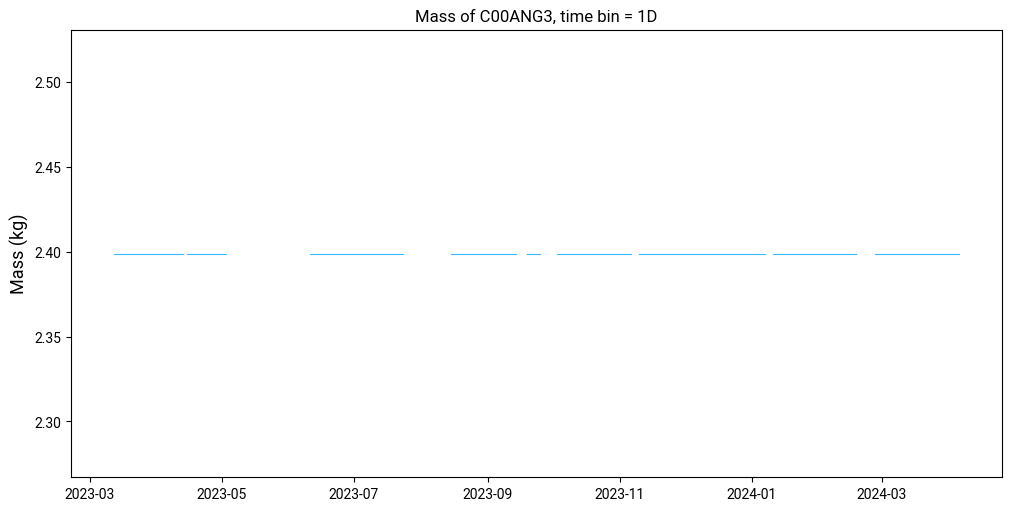

In [119]:
freq = '1D'

fig, ax         = plt.subplots(figsize=(10, 5))
data_LAr_coax   = df_skm[(df_skm.coincident_spms==False)&(df_skm.geds_name=='C00ANG3')]
g_data_LAr_coax = data_LAr_coax.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
g_data_LAr_coax_mass = data_LAr_coax.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).geds_mass.mean()/1000
ax.plot(g_data_LAr_coax_mass.index, g_data_LAr_coax_mass, lw=0.8, color=det_colors[2], alpha=0.8, label=f'C00ANG3', zorder=1)
plt.title(f'Mass of C00ANG3, time bin = {freq}')
plt.ylabel('Mass (kg)', fontsize=13)
plt.show()

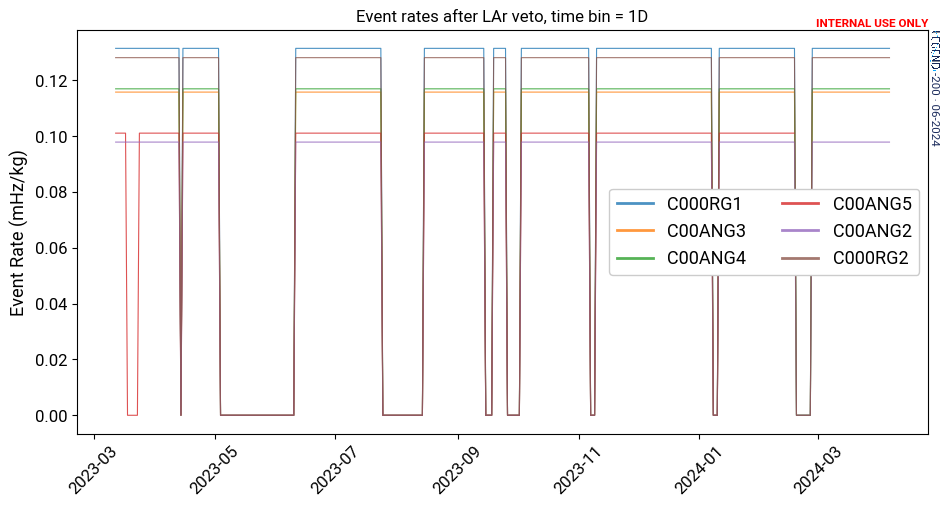

In [98]:
data_filt_det_mass_series = resample_df_norm_mass(data_det)

freq = '1D'

fig, ax         = plt.subplots(figsize=(10, 5))
data_LAr_coax   = df_skm[(df_skm.coincident_spms==False)&(df_skm.geds_type=='coax')]
g_data_LAr_coax = data_LAr_coax.groupby(pd.Grouper(key='trigger_timestamp', freq=freq)).size()*(1000/3600)
#ax.plot(g_data_LAr_coax.index, g_data_LAr_coax, lw=0.8, color=det_colors[2], alpha=0.8, label=f'Coax', zorder=1)

for coax in data_LAr_coax.geds_name.unique():
    df_each_coax_mass = resample_df_norm_mass(data_LAr_coax[data_LAr_coax.geds_name==coax], timestamp=freq)
    ax.plot(df_each_coax_mass.index, df_each_coax_mass, lw=0.8, alpha=0.8, label=coax, zorder=1)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title(f'Event rates after LAr veto, time bin = {freq}')
plt.ylabel('Event Rate (mHz/kg)', fontsize=13)
leg = plt.legend(fontsize=13, ncol=2, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2)
legendstyles.legend_watermark(ax, logo_suffix="-200")
#plt.yscale('log')
plt.show()

## Plot the rates for each run

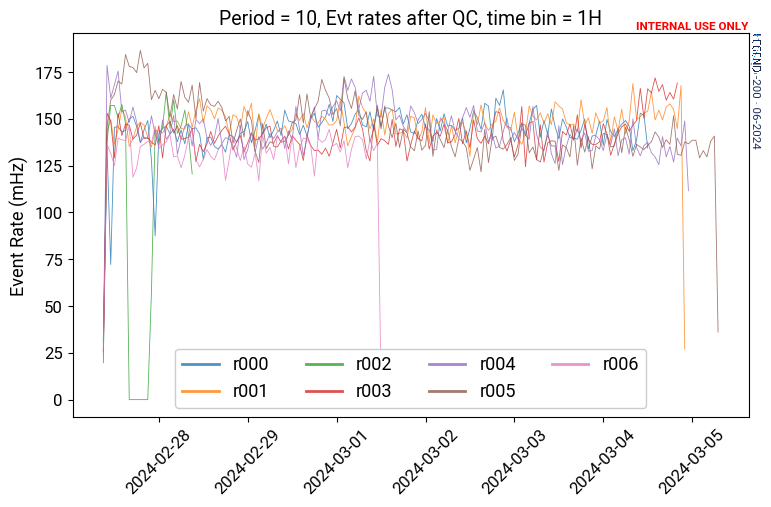

In [151]:
freq = '1H'

for period in df_skm.period.unique():
    if period==10:
        fig, ax = plt.subplots(figsize=(8, 5))
        df_skm_per = df_skm[df_skm.period==period]
        for i, run in enumerate(df_skm[df_skm.period==period].run.unique()):
            df_skm_per_run = df_skm_per[df_skm_per.run==run]
            df_skm_per_run['normalized_timestamp'] = df_skm_per_run.trigger_timestamp - (df_skm_per_run.trigger_timestamp.min() - df_skm_per.trigger_timestamp.min())
            g_data_p_r = df_skm_per_run.groupby(pd.Grouper(key='normalized_timestamp', freq=freq)).size()*(1000/3600)
            plt.plot(g_data_p_r.index, g_data_p_r, label=f'r{run:03d}', lw=0.6, alpha=0.8)
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.ylabel('Event Rate (mHz)', fontsize=13)
        plt.title(f'Period = {period}, Evt rates after QC, time bin = {freq}', fontsize=14)
        leg = plt.legend(fontsize=13, ncol=4, framealpha=1, loc='lower center')
        for line in leg.get_lines():
            line.set_linewidth(2)
        legendstyles.legend_watermark(ax, logo_suffix="-200")
        plt.show()